## Training Word Embeddings from Scratch
This notebook walks through the steps to train word embedding using continuous bag-of-word (CBOW) model, introduced by Mikolov et al (2013) using numpy. The script is modified from a notebook used in the Natural Language Processing Specialization provided by deeplearning.ai.

In [4]:
# import libraries used.
from bs4 import BeautifulSoup
from collections import defaultdict
import nltk
import numpy as np
import pandas as pd
import re
from scipy import linalg



## Preprocessing: parsing xml file.
I used an early version of wikipeidia(around 2006, obtained from http://mattmahoney.net/dc/textdata.html). The wikipedia dump is saved using xml file format. Here we used the BeautifulSoup library to read in the file, selected only the content part of the dump (xml files have many tages) and converted the file to txt format for further processing.

In [5]:
# Parse xml file, extract text content and save as text file.
'''
with open('enwiki8.xml', 'r') as f:
    data = f.read()
    
    data_parsed = BeautifulSoup(data, "xml")
    text = data_parsed.find_all('text', attrs={'xml:space':'preserve'})
    df = pd.DataFrame({'Text': text})
    
    
    #df = df.head(3000)
    
    #df['Text'] = df['Text'].replace('</text>', '', inplace = True)                                        
    
    df.to_csv('enwiki.txt', index = False, encoding = 'utf8', header = None, sep = ' ', mode = 'a')
'''

'\nwith open(\'enwiki8.xml\', \'r\') as f:\n    data = f.read()\n    \n    data_parsed = BeautifulSoup(data, "xml")\n    text = data_parsed.find_all(\'text\', attrs={\'xml:space\':\'preserve\'})\n    df = pd.DataFrame({\'Text\': text})\n    \n    \n    #df = df.head(3000)\n    \n    #df[\'Text\'] = df[\'Text\'].replace(\'</text>\', \'\', inplace = True)                                        \n    \n    df.to_csv(\'enwiki.txt\', index = False, encoding = \'utf8\', header = None, sep = \' \', mode = \'a\')\n'

## Preprcessing: Read in words and Make Dictionary
Here, we first read in the words in the wikipedia content text file, keep only letters in the alphabet (lower case) and use these words to make a dictionary mapping each unique word to a number (index). This is a required step for most natural language processing tasks.

In [6]:
# Load, tokenize and process the data
with open('enwiki.txt') as f:
    data = f.read()                                                 #  Read in the data
data = re.sub(r'[,!?;-]', '.',data)                                 #  Replace punctuations with .
data = nltk.word_tokenize(data)                                     #  Tokenize string to words
data = [ ch.lower() for ch in data if ch.isalpha() or ch == '.']    #  Convert words into lower case ones and keep only letters.
print("Number of tokens:", len(data),'\n', data[:15])               

Number of tokens: 161562852 
 ['text', 'xml', 'preserve', 'redirect', 'aaa', 'text', 'xml', 'preserve', 'redirect', 'algeria', 'r', 'from', 'camelcase', 'text', 'xml']


The FreqDist function of nltk library is used to have a quick look on the most common words appeared in the document.

In [7]:
fdist = nltk.FreqDist(word for word in data)
print("Size of vocabulary: ",len(fdist) )
print("Most frequent tokens: ",fdist.most_common(20) ) # print the 20 most frequent words and their freq.

Size of vocabulary:  268645
Most frequent tokens:  [('.', 17410620), ('the', 9884760), ('of', 5802540), ('and', 3892380), ('in', 3459600), ('to', 2946096), ('a', 2945760), ('is', 1755408), ('as', 1228380), ('for', 1111800), ('by', 1048428), ('that', 1023876), ('was', 1002336), ('with', 890412), ('on', 833268), ('gt', 804072), ('are', 740880), ('it', 726696), ('from', 681672), ('or', 657324)]


In [8]:
# Iterate all words in the document to create two dictionaries:
# WordToInd_d: mapping unique word to number.
# IndToWord: mapping number to unique word.

WordToInd_d = dict()
IndToWord = dict()
WordInd = 0
for tok in data:
    if tok not in WordToInd_d:
        WordToInd_d[tok] = WordInd
        IndToWord[WordInd] = tok
        WordInd += 1
    
WordToInd_d['Unk'] = WordInd
IndToWord[WordInd] = 'Unk'

#print out the example of "you" in the dictionary
print(WordToInd_d['you'])   
print(IndToWord[858])   
  

858
you


## Model Buildup: Define Model Architecture
We use a two-layer neural network model to train word embeddings. The task for training the model is to predict center word given context word (e.g. in "shall I **_centerword_** to a", we predict the centerword with a windows size of 2). The word embedding are actually weights of the trained model for each word in the corpus. The structure of the model is:
\begin{align}
 h &= W_1 \  X + b_1  \tag{1} \\
 a &= ReLU(h)  \tag{2} \\
 z &= W_2 \  a + b_2   \tag{3} \\
 \hat y &= softmax(z)   \tag{4} \\
\end{align}

The dimension of the weight and biase matrices in the first and second layer is defined in the initialize_model funciton below.

In [9]:
def initialize_model(N,V, random_seed=1):
    '''
    Inputs: 
        N:  dimension of hidden vector 
        V:  dimension of vocabulary
        random_seed: random seed for consistent results in the unit tests
     Outputs: 
        W1, W2, b1, b2: initialized weights and biases
    '''
    
    np.random.seed(random_seed)    

    # The weight matrix of layer 1 (W1) is of size N by V, where 
    # N is the predefined dimension of hidden layer(a hyperparameter)
    # V is the size of the corpus(or the dictionary created above).
    W1 = np.random.rand(N,V)
    # The weight matrix of layer 2 (W2) is of shape (V,N)
    W2 = np.random.rand(V,N)
    # The bias matrix of layer 1 (W1) is of shape (N,1)
    b1 = np.random.rand(N,1)
    # The bias matrix of layer 2 (W2) is of shape (V,1)
    b2 = np.random.rand(V,1)


    return W1, W2, b1, b2

## Activation Function: Softmax
The activation function used for the final layer is softmax, defined below.
<br>
$$ \text{softmax}(z_i) = \frac{e^{z_i} }{\sum_{i=0}^{V-1} e^{z_i} }  \tag{5} $$

In [10]:
def softmax(z):
    '''
    Inputs: 
        z: output scores from the hidden layer
    Outputs: 
        yhat: prediction (estimate of y)
    '''
    
    # Calculate yhat (softmax)
    e_z = np.exp(z)
    yhat = e_z/np.sum(e_z,axis=0)
    
    return yhat

## Forward Propagation
In a two layer structure, the forward propagation step is relatively simple, the activation fuction on the hidden layer used is Relu, or the maximum of 0 and the output of the first layer.

In [11]:
def forward_prop(x, W1, W2, b1, b2):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        W1, W2, b1, b2:  matrices and biases to be learned
     Outputs: 
        z:  output score vector
    '''
    
    ### START CODE HERE (Replace instances of 'None' with your own code) ###
    
    # Calculate h
    h = np.dot(W1,x)+b1
    
    # Apply the relu on h (store result in h)
    h = np.maximum(0,h)
    
    # Calculate z
    z = np.dot(W2,h)+b2
    
    ### END CODE HERE ###

    return z, h

## Cost function: Cross Entropy
The cost function used is cross entropy, which is sum of the difference of log probability between y and y hat.

In [12]:

def compute_cost(y, yhat, batch_size):
    # cost function 
    logprobs = np.multiply(np.log(yhat),y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

## Helper Functions

In [13]:
def get_batches(data, word2Ind, V, C, batch_size):
    batch_x = []
    batch_y = []
    for x, y in get_vectors(data, word2Ind, V, C):
        while len(batch_x) < batch_size:
            batch_x.append(x)
            batch_y.append(y)
        else:
            yield np.array(batch_x).T, np.array(batch_y).T
            batch = []

In [14]:
def get_idx(words, word2Ind):
    idx = []
    for word in words:
        idx = idx + [word2Ind[word]]
    return idx

In [15]:
def get_vectors(data, word2Ind, V, C):
    i = C
    while True:
        y = np.zeros(V)
        x = np.zeros(V)
        center_word = data[i]
        y[word2Ind[center_word]] = 1
        context_words = data[(i - C):i] + data[(i+1):(i+C+1)]
        num_ctx_words = len(context_words)
        for idx, freq in pack_idx_with_frequency(context_words, word2Ind):
            x[idx] = freq/num_ctx_words
        yield x, y
        i += 1
        if i >= len(data):
            print('i is being set to 0')
            i = 0

In [16]:
def pack_idx_with_frequency(context_words, word2Ind):
    freq_dict = defaultdict(int)
    for word in context_words:
        freq_dict[word] += 1
    idxs = get_idx(context_words, word2Ind)
    packed = []
    for i in range(len(idxs)):
        idx = idxs[i]
        freq = freq_dict[context_words[i]]
        packed.append((idx, freq))
    return packed

## Back Propagation
Back propagation defins the use of the difference between predicted and actual label to adjust weights using partial derivatives. 


In [17]:
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        yhat: prediction (estimate of y)
        y:  target vector
        h:  hidden vector (see eq. 1)
        W1, W2, b1, b2:  matrices and biases  
        batch_size: batch size 
     Outputs: 
        grad_W1, grad_W2, grad_b1, grad_b2:  gradients of matrices and biases   
    '''
    
    # Compute l1 as W2^T (Yhat - Y)
    # Re-use it whenever you see W2^T (Yhat - Y) used to compute a gradient
    l1 = np.dot(W2.T,(yhat-y))
    # Apply relu to l1
    l1 = np.maximum(0,l1)
    # Compute the gradient of W1
    
    grad_W1 = (1/batch_size)*np.dot(l1,x.T)    #1/m * relu(w2.T(yhat-y)) . xT
    # Compute the gradient of W2
    grad_W2 = (1/batch_size)*np.dot(yhat-y,h.T)
    # Compute the gradient of b1
    grad_b1 = np.sum(l1,axis=1,keepdims=True)/batch_size
    # Compute the gradient of b2
    grad_b2 = np.sum(yhat - y,axis=1,keepdims=True)/batch_size

    
    return grad_W1, grad_W2, grad_b1, grad_b2

## Gradient Descent:
Gradient descent defines the the hyperparameters (e.g. batch size, number of iterations) and combined the functions defined above to train the model for word embedding.

In [18]:
def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03):
    
    '''
    This is the gradient_descent function
    
      Inputs: 
        data:      text
        word2Ind:  words to Indices
        N:         dimension of hidden vector  
        V:         dimension of vocabulary 
        num_iters: number of iterations  
     Outputs: 
        W1, W2, b1, b2:  updated matrices and biases   

    '''
    W1, W2, b1, b2 = initialize_model(N,V, random_seed=282)
    batch_size = 128
    iters = 0
    C = 2
    for x, y in get_batches(data, WordToInd_d, V, C, batch_size):
        # Get z and h
        z, h = forward_prop(x, W1, W2, b1, b2)
        # Get yhat
        yhat = softmax(z)
        # Get cost
        cost = compute_cost(y, yhat, batch_size)
        if ( (iters+1) % 10 == 0):
            print(f"iters: {iters + 1} cost: {cost:.6f}")
        # Get gradients
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)
        
        # Update weights and biases
        W1 -= alpha*grad_W1 
        W2 -= alpha*grad_W2
        b1 -= alpha*grad_b1
        b2 -= alpha*grad_b2
        
        
        iters += 1 
        if iters == num_iters: 
            break
        if iters % 100 == 0:
            alpha *= 0.66
            
    return W1, W2, b1, b2

In [19]:
# test your function
C = 2
N = 50

V = len(WordToInd_d)
num_iters = 150
print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(data, WordToInd_d, N, V, num_iters)

Call gradient_descent
iters: 10 cost: 0.234494
iters: 20 cost: 0.046635
iters: 30 cost: 0.025789
iters: 40 cost: 0.017818
iters: 50 cost: 0.013611
iters: 60 cost: 0.011012
iters: 70 cost: 0.009246
iters: 80 cost: 0.007968
iters: 90 cost: 0.007001
iters: 100 cost: 0.006243
iters: 110 cost: 0.005808
iters: 120 cost: 0.005447
iters: 130 cost: 0.005128
iters: 140 cost: 0.004844
iters: 150 cost: 0.004590


In [20]:
# visualizing the word vectors here
%matplotlib inline
%matplotlib notebook
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['king', 'queen','lord','man', 'woman','dog','wolf',
         'rich','happy','sad']

embs = (W1.T + W2)/2.0
 
# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [WordToInd_d[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)  # X.shape:  Number of words of dimension N each 

(10, 50) [85, 5911, 5736, 265, 4585, 7221, 6245, 8074, 4701, 13912]


In [21]:
def compute_pca(data, n_components=2):
    """
    Input: 
        data: of dimension (m,n) where each row corresponds to a word vector
        n_components: Number of components you want to keep.
    Output: 
        X_reduced: data transformed in 2 dims/columns + regenerated original data
    pass in: data as 2D NumPy array
    """

    m, n = data.shape

    # mean center the data
    data -= data.mean(axis=0)
    # calculate the covariance matrix
    R = np.cov(data, rowvar=False)
    # calculate eigenvectors & eigenvalues of the covariance matrix
    # use 'eigh' rather than 'eig' since R is symmetric,
    # the performance gain is substantial
    evals, evecs = linalg.eigh(R)
    # sort eigenvalue in decreasing order
    # this returns the corresponding indices of evals and evecs
    idx = np.argsort(evals)[::-1]

    evecs = evecs[:, idx]
    # sort eigenvectors according to same index
    evals = evals[idx]
    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    evecs = evecs[:, :n_components]

    return np.dot(evecs.T, data.T).T


In [33]:
result= compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show();

<IPython.core.display.Javascript object>


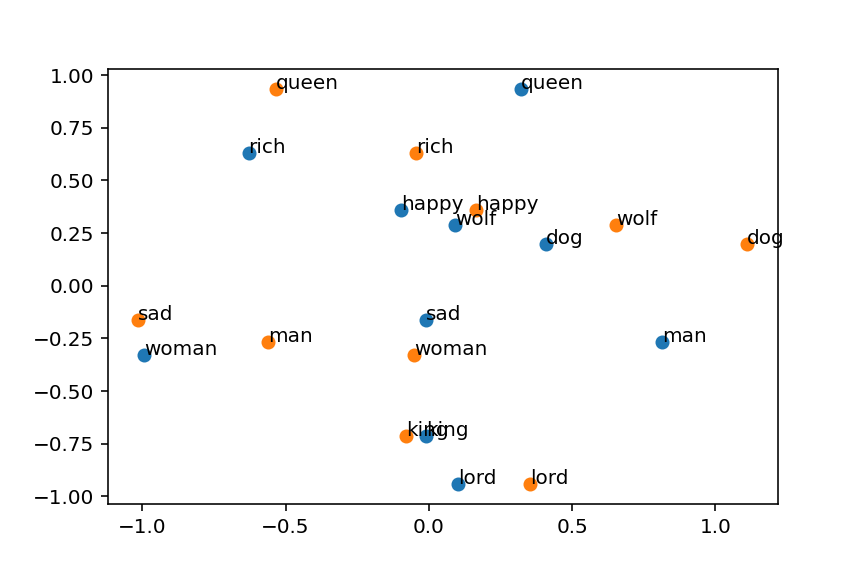

In [32]:
result= compute_pca(X, 4)
pyplot.scatter(result[:, 3], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 3], result[i, 1]))
pyplot.show();

## Word Analogy Task

### Cosine Similarity
Cosine similarity is defined as:
$$\cos (\theta)=\frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\|\|\mathbf{B}\|}=\frac{\sum_{i=1}^{n} A_{i} B_{i}}{\sqrt{\sum_{i=1}^{n} A_{i}^{2}} \sqrt{\sum_{i=1}^{n} B_{i}^{2}}}\tag{1}$$
where $A$ and $B$ represent the word vectors and $A_i$ or $B_i$ represent index i of that vector.

In [24]:
def cosine_similarity(A, B):
    '''
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        cos: numerical number representing the cosine similarity between A and B.
    '''


    
    dot = np.dot(A, B)
    norma = np.linalg.norm(A)
    normb = np.linalg.norm(B)
    cos = dot/(norma*normb)

    return cos

In [25]:

king = embs[WordToInd_d['king']]
queen = embs[WordToInd_d['queen']]

cosine_similarity(king, queen)

0.8650999066896116

In [26]:
def euclidean(A, B):
    """
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        d: numerical number representing the Euclidean distance between A and B.
    """



    d = np.linalg.norm(A-B)

    return d



In [27]:
euclidean(king, queen)

2.0451460883554695

In [35]:
#Find Analogy


Pair1A_emb = embs[WordToInd_d['france']]

Pair1B_emb = embs[WordToInd_d['paris']]


Pair2A_emb = embs[WordToInd_d['germany']]

vec = Pair1A_emb - Pair1B_emb + Pair2A_emb


similarity = -1

group = set(('france', 'paris', 'germany'))

Answer = ''

# loop through all words in the embeddings dictionary
for word in WordToInd_d.keys():

    # first check that the word is not already in the 'group'
    if word not in group:
        # get the word embedding
        word_emb = embs[WordToInd_d[word]]

        # calculate cosine similarity between embedding of country 2 and the word in the embeddings dictionary
        cur_similarity = cosine_similarity(vec, word_emb)

            # if the cosine similarity is more similar than the previously best similarity...
        if cur_similarity > similarity:

            # update the similarity to the new, better similarity
            similarity = cur_similarity

            # store the country as a tuple, which contains the word and the similarity
            Answer = (word, similarity)

print(Answer)

('zembabwei', 0.8972798929059899)


## Reference
Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient estimation of word representations in vector space. In ICLR.